- fast connection of questions.csv
- calculate first_attempt in advance

In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation
from bitarray import bitarray

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc="progress: ")

_ = np.seterr(divide='ignore', invalid='ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Preprocess

In [3]:
data_types_dict = {
    #'row_id': 'uint32',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [4]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)

In [5]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 3],
    dtype={'question_id': 'int16', 'part': 'int8'}
)
train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
train_df.drop(columns=['question_id'], inplace=True)

In [6]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)
del cum

In [7]:
train_df["reading_part"] = train_df["part"] >=5
train_df["reading_part"] = train_df["reading_part"].astype("int8")
train_df['reading_part_lag'] = train_df.groupby('user_id')["reading_part"].shift()
cum = train_df.groupby('user_id')['reading_part_lag'].agg(['cumsum']) 
train_df['reading_part_ratio'] = cum['cumsum'] 
train_df.drop(columns=['reading_part_lag', 'reading_part'], inplace=True)
del cum

In [8]:
train_df["listening_part"] = (train_df["part"] >=1) | (train_df["part"] <=4)
train_df["listening_part"] = train_df["listening_part"].astype("int8")
train_df['listening_part_lag'] = train_df.groupby('user_id')["listening_part"].shift()
cum = train_df.groupby('user_id')['listening_part_lag'].agg(['cumsum']) 
train_df['listening_part_ratio'] = cum['cumsum'] 
train_df.drop(columns=['listening_part_lag', 'listening_part'], inplace=True)
del cum

In [9]:
#train_df["first_attempt"] = train_df[["row_id", "user_id", "content_id"]].groupby("user_id").progress_apply(lambda x: 
#                                                                    pd.DataFrame(np.isin(x["row_id"].values, x.drop_duplicates("content_id")["row_id"].values))).values
#train_df.drop("row_id", axis=1, inplace=True)
first_attempt_df = pd.read_csv("../input/riiid-additional-data/content_first_attempt.csv")
train_df["first_attempt"] = first_attempt_df.first_attempt
del first_attempt_df

In [10]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

In [11]:
user_listening_agg = train_df.groupby('user_id')["listening_part_ratio"].agg(['max'])
user_reading_agg = train_df.groupby('user_id')["reading_part_ratio"].agg(['max'])
user_reading_agg['max'].fillna(0,inplace=True)
user_listening_agg['max'].fillna(0,inplace=True)

In [12]:
%%time
user_content_agg = train_df.groupby("user_id")["content_id"].unique().reset_index().set_index("user_id")

value = []
for j in user_content_agg.index:
    a = bitarray(32737, endian='little')
    a.setall(True)
    for i in user_content_agg.loc[j][0]:
        a[i] = 0
    value.append(a)
    
user_content_agg["content_exp"] = value

CPU times: user 2min 5s, sys: 3.25 s, total: 2min 8s
Wall time: 2min 8s


In [13]:
train_df["count"] = 1
train_df["count"] = train_df.groupby("user_id")["count"].cumsum()

In [14]:
train_df = train_df.groupby('user_id').tail(24).reset_index(drop=True)

In [15]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

In [16]:
valid_df = train_df.groupby('user_id').tail(6)
train_df.drop(valid_df.index, inplace=True)

In [17]:
train_df.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part,user_correctness,reading_part_ratio,listening_part_ratio,first_attempt,count,content_count
0,115,0.687217,0,19000.0,False,1,0.727273,2.0,22.0,True,23,36674
1,115,0.608222,0,21000.0,False,1,0.695652,2.0,23.0,True,24,47047
2,115,0.601824,1,22000.0,False,1,0.666667,2.0,24.0,True,25,40452
3,115,0.418436,1,16000.0,False,1,0.680000,2.0,25.0,True,26,190170
4,115,0.474545,1,20000.0,False,1,0.692308,2.0,26.0,True,27,56707


# Train

In [18]:
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count',
    'count',
    'reading_part_ratio',
    'listening_part_ratio',
    'first_attempt',
]

params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.756817	valid_1's auc: 0.741142
[100]	training's auc: 0.759094	valid_1's auc: 0.74385
[150]	training's auc: 0.760175	valid_1's auc: 0.74499
[200]	training's auc: 0.760673	valid_1's auc: 0.745348
[250]	training's auc: 0.761031	valid_1's auc: 0.745554
[300]	training's auc: 0.761374	valid_1's auc: 0.74575
[350]	training's auc: 0.761702	valid_1's auc: 0.74591
[400]	training's auc: 0.762005	valid_1's auc: 0.746045
[450]	training's auc: 0.762281	valid_1's auc: 0.746156
[500]	training's auc: 0.762532	valid_1's auc: 0.746244
[550]	training's auc: 0.762767	valid_1's auc: 0.746331
[600]	training's auc: 0.762998	valid_1's auc: 0.746402
[650]	training's auc: 0.763246	valid_1's auc: 0.746485
[700]	training's auc: 0.763454	valid_1's auc: 0.746533
[750]	training's auc: 0.763681	valid_1's auc: 0.746593
[800]	training's auc: 0.763951	valid_1's auc: 0.746692
[850]	training's auc: 0.764158	valid_1's auc: 0.746721
[900]	tra

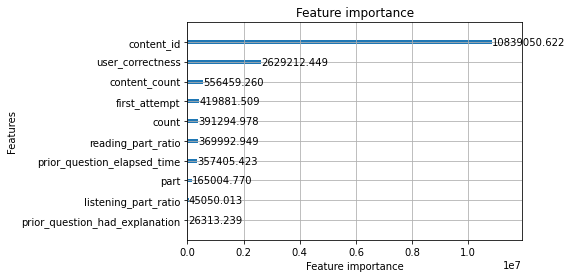

In [19]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

model = lgb.train(
    params, 
    tr_data, 
    num_boost_round=10000,
    valid_sets=[tr_data, va_data], 
    early_stopping_rounds=50,
    verbose_eval=50
)

lgb.plot_importance(model, importance_type='gain')
plt.show()

# Inference

In [20]:
def make_bitarray():
    a = bitarray(32737, endian='little')
    a.setall(True)   
    return a

user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))
user_reading_dict = user_reading_agg['max'].astype('int32').to_dict(defaultdict(int))
user_listening_dict = user_listening_agg['max'].astype('int32').to_dict(defaultdict(int))
user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(make_bitarray))

In [21]:
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [22]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        parts = prior_part_arrays
        
        for user_id, content_id, answered_correctly, part in zip(user_ids, content_ids, targets, parts):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1
            if part <=4:
                user_listening_dict[user_id] +=1
            else:
                user_reading_dict[user_id] +=1

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    prior_part_arrays = test_df['part'].values
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    listening_count = np.zeros(len(test_df), dtype=np.int32)
    reading_count = np.zeros(len(test_df), dtype=np.int32)
    first_attempt_values = []
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
        listening_count[i] = user_listening_dict[user_id]
        reading_count[i] = user_reading_dict[user_id]
        first_attempt_values.append(user_content_dict[user_id][content_id])
        user_content_dict[user_id][content_id] = False 

    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
    test_df['count'] = 1
    test_df['count'] = test_df.groupby("user_id")["count"].cumsum()
    test_df['count'] += user_count
    test_df['reading_part_ratio'] = reading_count
    test_df['listening_part_ratio'] = listening_count
    test_df["first_attempt"] = first_attempt_values
    
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])

CPU times: user 1.22 s, sys: 48 ms, total: 1.27 s
Wall time: 755 ms
